# Computing Initial and Terminal States

## Preliminaries

In this tutorial, you will learn how to use the {class}`~cellrank.estimators.GPCCA` to do the following:

- compute macrostates of cellular dynamics.
- visualize a coarse-grained transition matrix among macrostates.
- classify macrostates as initial, terminal or intermediate.

The {class}`~cellrank.estimators.GPCCA` may be combined with **any** CellRank {mod}`kernel <cellrank.kernels>` used to compute a cell-cell transition matrix, including the {class}`~cellrank.kernels.VelocityKernel`, the {class}`~cellrank.kernels.PseudotimeKernel` and the {class}`~cellrank.kernels.CytoTRACEKernel`. We explain the kernel/estimator paradigm in more detail in our {doc}`getting_started` tutorial. 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/main/tutorials/initial_terminal_states.ipynb).

:::{figure-md} fig-structure

<img src="_static/img/initial_terminal.jpg" width="600" alt="The GPCCA estimator computes initial and terminal states based on Generalized Perron Cluster Cluster Analysis.  ">

**CellRank decomposes cellular dynamics into macrostates:** Based on Generalized Perron Cluster Cluster analysis (GPCCA), CellRank identifies {attr}`~cellrank.estimators.GPCCA.macrostates` of cellular dynamics, which include initial, intermediate, and terminal states {cite}`reuter:18,reuter:19,lange:22`. 
:::

:::{note}

If you want to run this on your own data, you will need:

- a scRNA-seq dataset for which you computed a cell-cell transition matrix using any CellRank {mod}`kernel <cellrank.kernels>`. For each kernel, there exist individual tutorials that teach you how to use them. For example, we have tutorials about using {doc}`RNA velocity <cellrank_meets_rna_velocity`, {doc}`experimental time points <cellrank_meets_real_time>`, and {doc}`pseudotime <cellrank_meets_pseudotime>`, among others, to derive cell-cell transition probabilities. 

:::

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

### Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

In [2]:
import numpy as np
import scipy.stats as st

import cellrank as cr
import scanpy as sc

cr.settings.verbosity = 2
sc.settings.set_figure_params(
    frameon=False,
    dpi=100,
)

Global seed set to 0


In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of pancreas development at embyonic day E15.5 {cite}`bastidas-ponce:19`. We used this dataset in our {doc}`CellRank meets RNA velocity tutorial <cellrank_meets_rna_velocity>` to compute a cell-cell transition matrix using the {class}`~cellrank.kernels.VelocityKernel`; this tutorial builds on the transition matrix computed there. 

In [4]:
adata = sc.read("datasets/ML_2023-06-08_pancreas_with_transition_matrix.h5ad")

vk = cr.kernels.VelocityKernel.from_adata(adata, key="T_fwd")
vk

VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=4.013]

:::{note}

The method {meth}`~cellrank.kernels.VelocityKernel.from_adata` allows you to reconstruct a CellRank kernel from an {class}`~anndata.AnnData` object. When you use a kernel to compute a transition matrix, this matrix, as well as a few informations about the computation, are written to the underlying {class}`anndata.AnnData` object upon calling {meth}`~cellrank.kernels.VelocityKernel.write_to_adata`. This makes it easy to write and read kernels from disk via the associated {class}`~anndata.AnnData` object. 

:::

As a reminder, below is a UMAP with cluster labels of this dataset {cite}`bastidas-ponce:19, mcinnes:18, becht:19`. In this tutorial, we will automatically identify the initial and terminal states. 

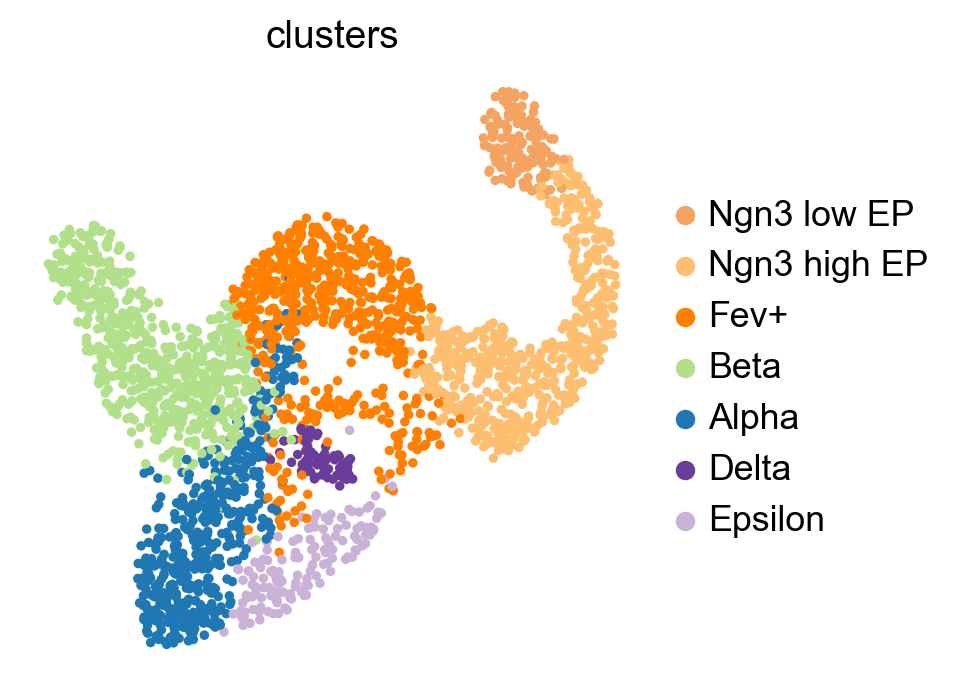

In [5]:
sc.pl.embedding(adata, basis="umap", color="clusters")

## Identify initial and terminal states

### Initialize an estimator 

The {mod}`~cellrank.estimators` allow you to analyze cell-state dynamics in CellRank. We initialize the {class}`GPCCA estimator <cellrank.estimators.GPCCA>` here by passing the {class}`~cellrank.kernels.VelocityKernel` {cite}`reuter:18,reuter:19`. However, the {class}`GPCCA estimator <cellrank.estimators.GPCCA>` works with *every* CellRank {mod}`kernel <cellrank.kernels>`. 

In [6]:
g = cr.estimators.GPCCA(vk)
print(g)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


We use the {class}`GPCCA estimator <cellrank.estimators.GPCCA>` below to compute initial & terminal states; it may further be used to compute fate probabilities as we explain in the {doc}`fate probabilities & driver genes tutorial <fate_probabilities>`. 

:::{note}

You can interact with the {class}`GPCCA estimator <cellrank.estimators.GPCCA>` in two ways:

- [basic usage](#basic-usage): via the {meth}`~cellrank.estimators.GPCCA.fit` and {meth}`~cellrank.estimators.GPCCA.predict` methods; this is very convenient but offers less control. 
- [advanced usage](#advanced-usage): by computing the {meth}`Schur decomposition <cellrank.estimators.GPCCA.compute_schur>`, the {meth}`macrostates <cellrank.estimators.GPCCA.compute_macrostates>`, etc. While there are a few more method calls involved here, it offers you more control. 
    
We demonstrate both modes in this tutorial. 

:::

### Basic usage

We fit the estimator; this computes a [Schur decompsition](https://en.wikipedia.org/wiki/Schur_decomposition) and uses the GPCCA algorithm as implemented in [pyGPCCA](https://pygpcca.readthedocs.io/en/latest/) to compute {attr}`~cellrank.estimators.GPCCA.macrostates` by maximizing for metastability {cite}`reuter:18,reuter:19,reuter:22`. {attr}`~cellrank.estimators.GPCCA.macrostates` may contain {attr}`initial <cellrank.estimators.GPCCA.initial_states>`, {attr}`terminal <cellrank.estimators.GPCCA.terminal_states>` and intermediate states of cellular dynamics.  

:::{figure-md} fig-gpcca

<img src="_static/img/gpcca_example.jpg" width="1000" alt="The GPCCA estimator computes initial and terminal states based on Generalized Perron Cluster Cluster Analysis.  ">

**Coarse-graining with GPCCA**: Using the GPCCA algorithm, CellRank coarse-grains a cell-cell transition matrix onto the macro-state level. We obtain two key outputs: the soft assignment of cells to {attr}`macrostates <cellrank.estimators.GPCCA.macrostates_memberships>`, and a matrix of transition probabilities among these macrostates {cite}`reuter:18, reuter:19, reuter:22`. 

:::

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Calculating minChi criterion in interval `[4, 12]`
Computing `4` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


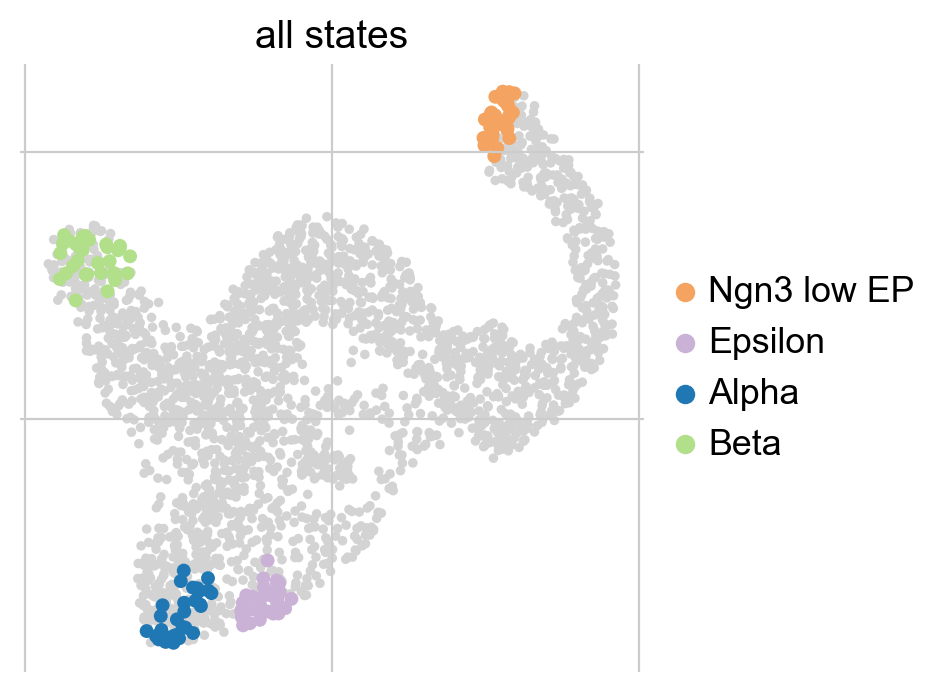

In [7]:
g.fit(cluster_key="clusters", n_states=[4, 12])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

Using `n_states=[a, b]`, we told the algorithm to scan this interval for the optimal number of macrostates. It identified 4 macrostates which we show above in the UMAP. For each macrostate, we display the `n_cells` cells most strongly associated with it. Each macrostate was automatically assigned a label by associating it with the cluster labels stored in {attr}`adata.obs['clusters'] <anndata.AnnData.obs>`; this is controled using `cluster_key`. 

You can check out the {mod}`pygpcca` documentation for more information on the macrostate computation. 

:::{note}

Make sure to have the scientific computing libraries [PETSc](https://petsc.org/release/) and [SLEPc](https://slepc.upv.es/) installed for maximum performance, using e.g. `conda install -c conda-forge petsc4py slepc4py`.  On most machines, this is strongly recommended if your datasets consists of over **10k cells**. See our {doc}`installation instructions <../../installation.rst`. 

:::

In the next step, we use the {meth}`~cellrank.estimators.GPCCA.predict_terminal_states` to identify terminal macrostates. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


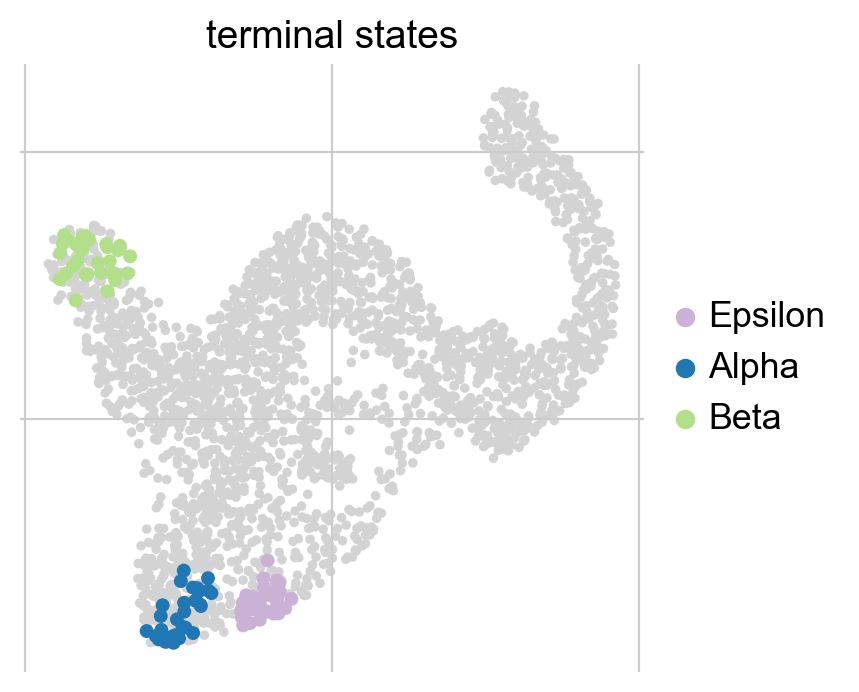

In [8]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

We automatically identified the Alpha, Beta and Epsilon states as terminal. While the plot above just shows the cells most confidently assigned to each terminal state, we can also plot the underlying continuous distribution for each macrostate.

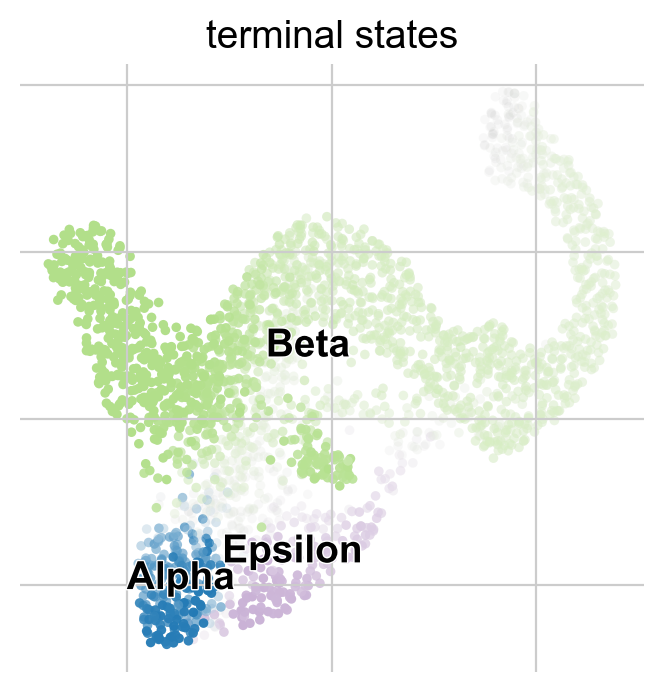

In [9]:
g.plot_macrostates(which="terminal", discrete=False)

Each cell is colored according to the terminal state it most likely belongs to; higher color intensity reflects greater confidence in the assignment.

:::{note}

These values should **not** be confused with {meth}`fate probabilities <cellrank.estimators.GPCCA.compute_fate_probabilities>`, they reflect our confidence in assigning a cell to a terminal state, but they don't tell us how likely a cell is to *reach* this terminal state. We demonstrate the computation of fate probabilities in the {doc}`fate probabilities & driver genes tutorial <fate_probabilities>`. 

:::

Analogously, we identify initial states using the {meth}`~cellrank.estimators.GPCCA.predict_initial_states` method. 

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


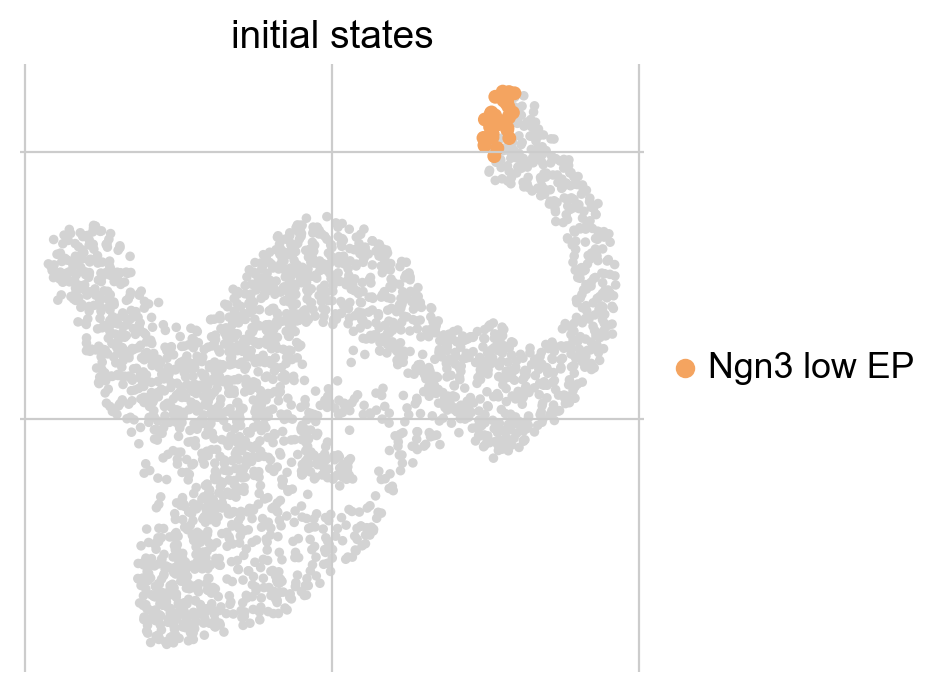

In [10]:
g.predict_initial_states()
g.plot_macrostates(which="initial", legend_loc="right", s=100)

This automatically identified the Ngn3 low EP state as initial, which is correct. Macrostates, and their classification as initial or terminal, are written to the {class}`GPCCA estimator <cellrank.estimators.GPCCA>` and can be inspected conveniently via {attr}`.~cellrank.estimators.GPCCA.initial_states` and {attr}`.~cellrank.estimators.GPCCA.terminal_states`. To get an overview, we can print the estimator. 

In [11]:
g

GPCCA[kernel=VelocityKernel[n=2531], initial_states=['Ngn3 low EP'], terminal_states=['Alpha', 'Beta', 'Epsilon']]

We can visually confirm our terminal state identification by comparing with well-known mature cell-type markers *Ins1* and *Ins2* for Beta cells, *Gcg* for Alpha cells and *Ghrl* for epsilon cells. To confirm our initial state identification, we visualize Ductal cell markers *Sox9*, *Anxa2* and *Bicc1*. 

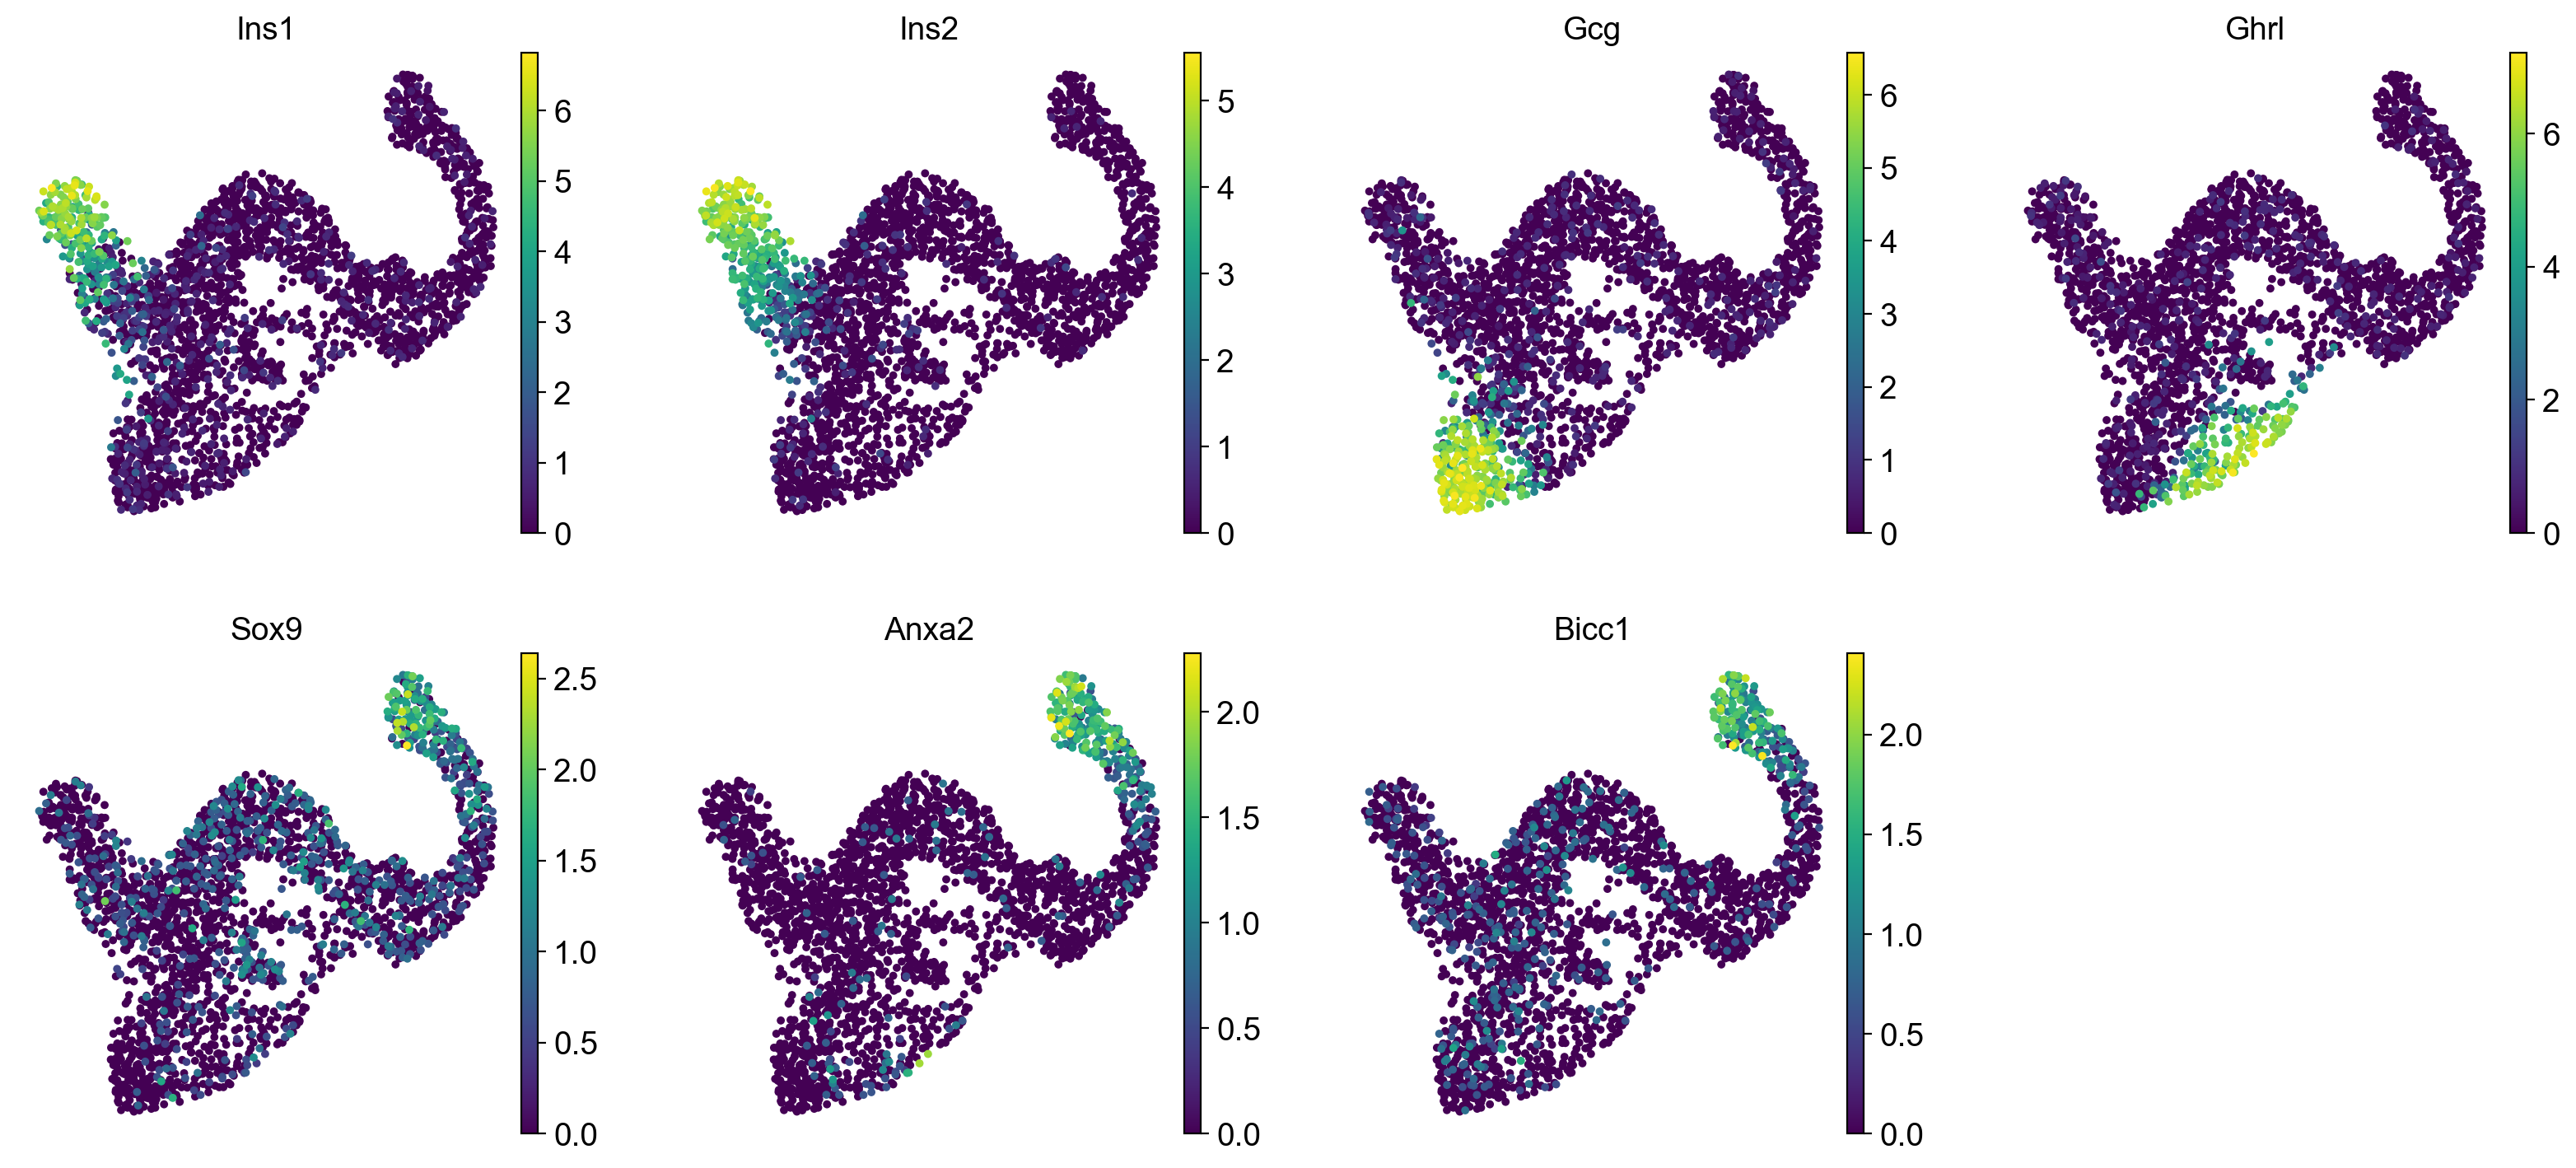

In [12]:
sc.pl.embedding(
    adata,
    basis="umap",
    color=["Ins1", "Ins2", "Gcg", "Ghrl", "Sox9", "Anxa2", "Bicc1"],
    size=50,
)

Visually, these marker genes agree well with automatically identified initial and terminal states. To make this a bit more quantitative, let's check whether our *terminal* Beta cells express *Ins1* at higher levels compared to other (non-terminal) Beta cells. 

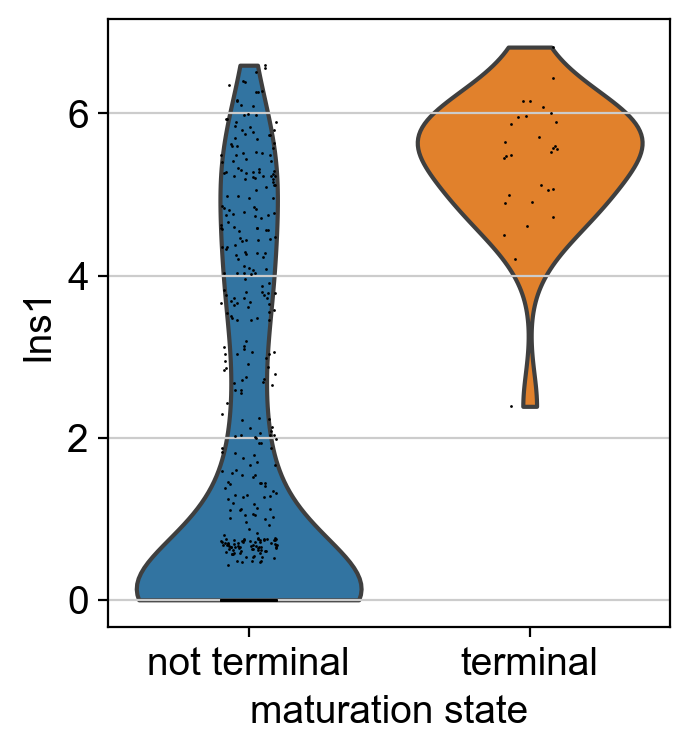

Ttest_indResult(statistic=12.758279519129177, pvalue=1.7212735169400435e-19)

In [13]:
# subset to just Beta cells
bdata = adata[adata.obs["clusters"] == "Beta"].copy()

# create an annotation for terminal vs. not-terminal
bdata.obs["maturation_state"] = np.where(
    bdata.obs["term_states_fwd"] == "Beta", "terminal", "not terminal"
)

# show distribution in violin plot
sc.pl.violin(bdata, keys=["Ins1"], groupby="maturation_state")

# use a simple t-test to quantify how different the two distributions are
a = bdata[bdata.obs["maturation_state"] == "terminal", "Ins1"].X.data
b = bdata[bdata.obs["maturation_state"] == "not terminal", "Ins1"].X.data
st.ttest_ind(a, b, equal_var=False)

This looks promising, the cells we automatically identified as terminal Beta cells express the maturation marker *Ins1* at significantly higher levels compared to other Beta cells. This can be a helpful technique to confirm automatic initial and terminal state identification in settings where prior knowledge is available. 

The classification of {attr}`~cellrank.estimators.GPCCA.macrostates` as initial or terminal is based on the {attr}`coarse grained transition matrix <cellrank.estimators.GPCCA.coarse_T`, as shown below.  

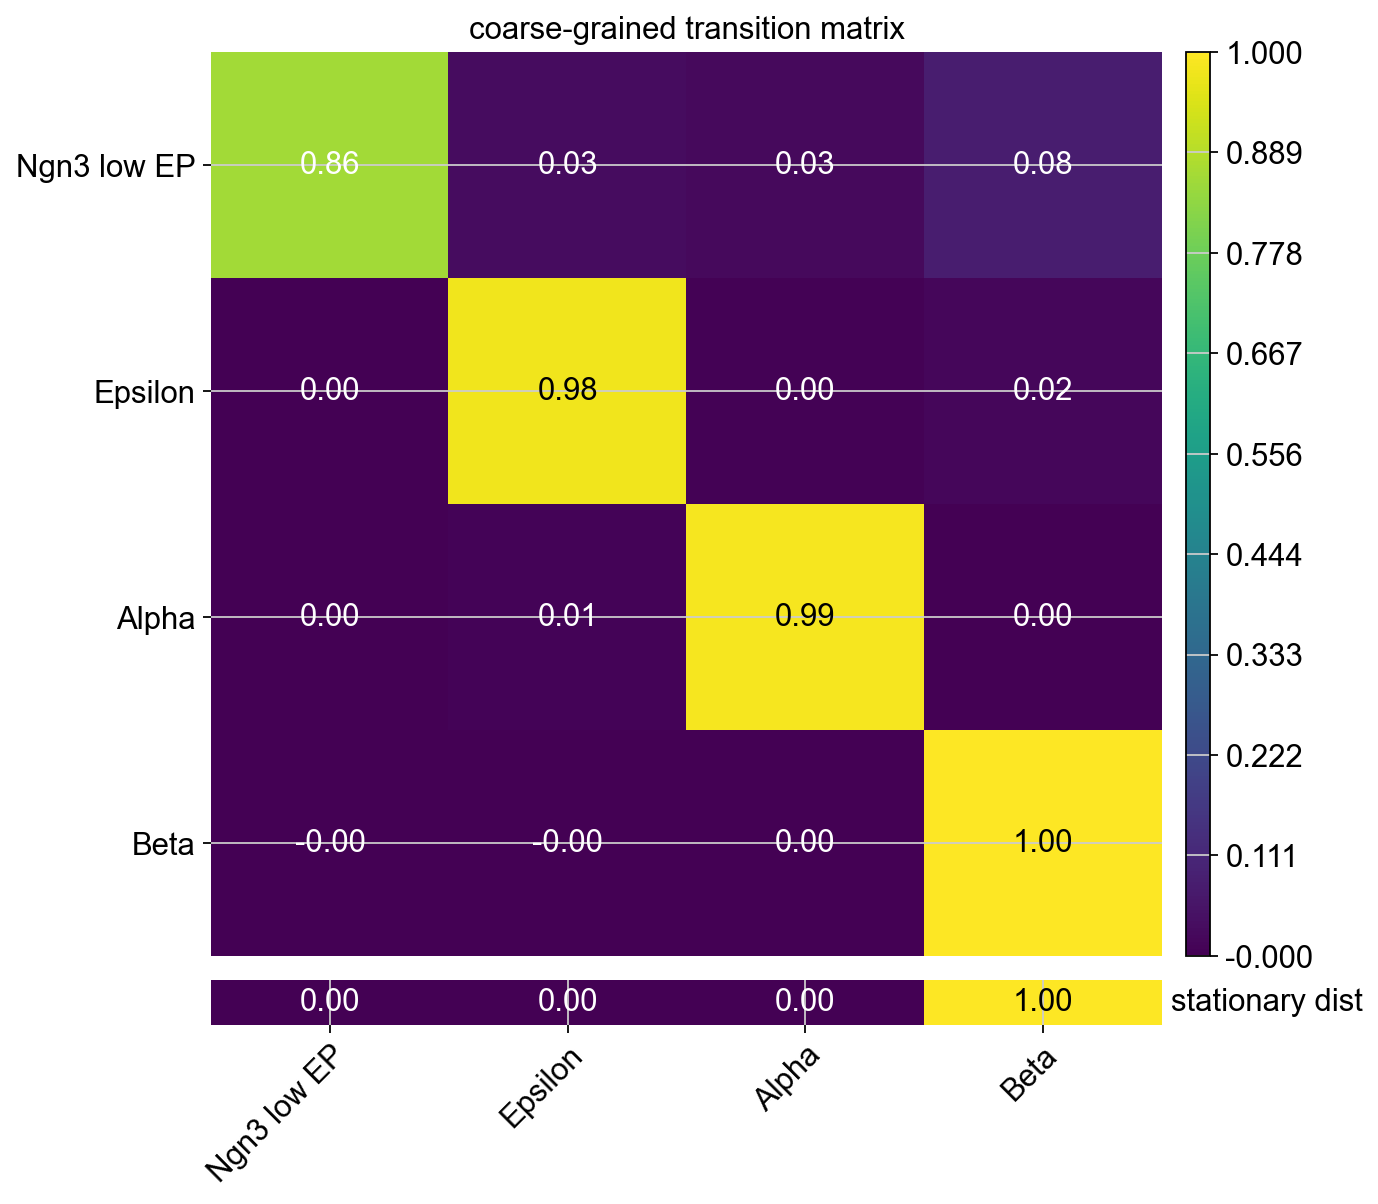

In [14]:
g.plot_coarse_T()

This transition matrix aggregates the single-cell Markov chain to a macrostate-level Markov chain. Entries in this matrix tell us how likely macrostates are to transition into one-another. We identify initial and terminal states based on the following criteria:

- {attr}`~cellrank.estimators.GPCCA.terminal_states` are very stable (large value on the diagonal). They can have incoming probability mass, but almost no outgoing probability mass. 
- {attr}`~cellrank.estimators.GPCCA.initial_states` are less stable (smaller values on the diagonal and in the coarse-grained stationary distribution). They can have outgoing, but almost no incoming probability mass. 
- intermediate states are just all remaining {attr}`~cellrank.estimators.GPCCA.macrostates` which we classified neither as terminal nor as initial. 

Note that the automatic identification does not always work perfectly. For example, we did not automatically identify the terminal Delta cell population in our analysis above. For this reason, we'll next explore the low-level mode to interact with the {class}`GPCCA estimator <cellrank.estimators.GPCCA` which offers a bit more control and supervision to bring in any prior knowledge that you might have about the biological system. 

### Advanced usage

Let's start with a new {mod}`estimator object <cellrank.estimators>`. 

In [15]:
g2 = cr.estimators.GPCCA(vk)
print(g2)

GPCCA[kernel=VelocityKernel[n=2531], initial_states=None, terminal_states=None]


The computation of macrostates is based on the real [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition) - essentially a generalization of the eigendecomposition. For non-symmetric transition matrices, as in our case, the eigendecomposition in general yields complex eigenvalues and eigenvectors, which are difficult to interpret. Thus, we revert to the real Schur decomposition {cite}`reuter:18,reuter:19`. 

Below, we also plot the real part of the top eigenvalues, sorted by their real part. Blue and orange denote real and complex eigenvalues, respectively. For real matrices, complex eigenvalues always appear in pairs of complex conjugates. 

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 10, 15, 18]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


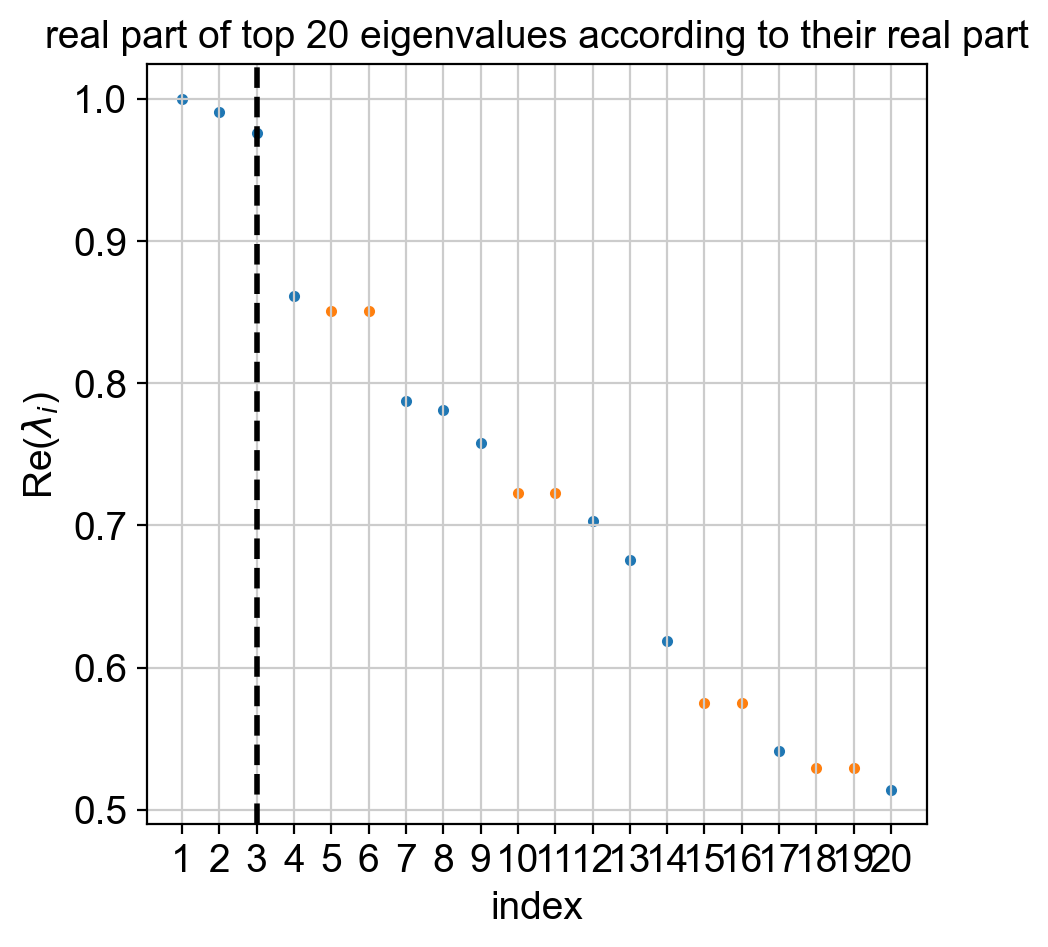

In [16]:
g2.compute_schur()
g2.plot_spectrum(real_only=True)

Using the {attr}`real Schur decomposition <cellrank.estimators.GPCCA.schur_matrix>`, we compute macrostates. In the plot above, the estimator automatically suggested a number of states to use (dashed vertical line); however, we will ignore that and compute a few more states to have a chance at identifying the Delta cell population. 

Computing `11` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)


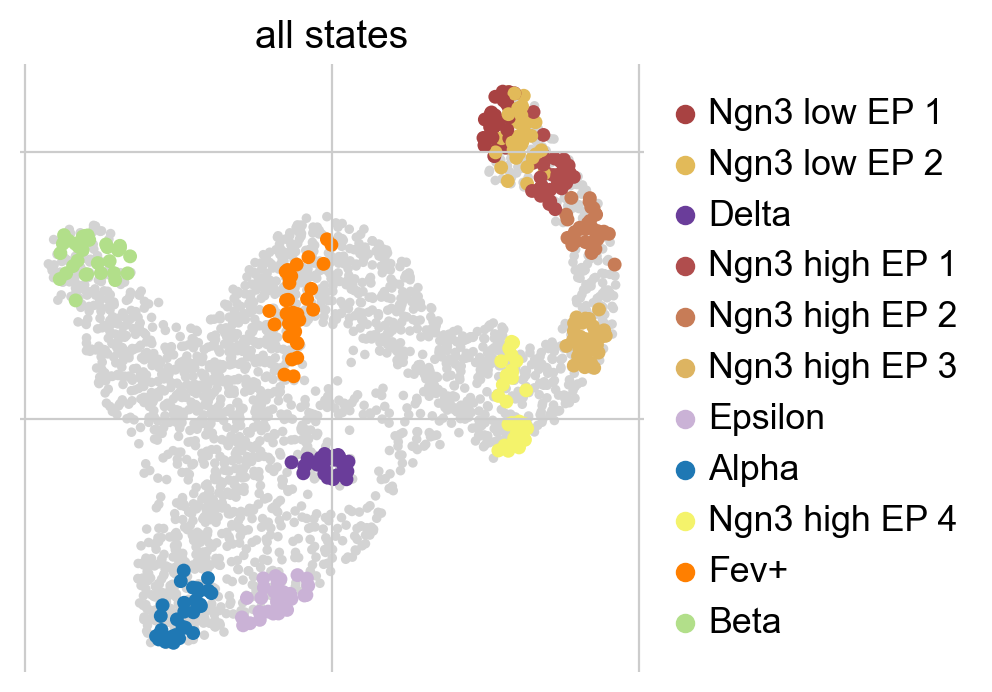

In [17]:
g2.compute_macrostates(n_states=11, cluster_key="clusters")
g2.plot_macrostates(which="all", legend_loc="right", s=100)

We now have macrostates for Alpha, Beta, Epsilon and Delta populations, besides a few progenitor populations. We assign one label per macrostate based on the underlying `'clusters'` annotation. However, that does not imply that all cells within one macrostate are from the same underlying cluster as we use majority voting. We can visualize the relationship between clusters and macrostates. We show below the distribution over cluster membership for each of the cells most confidently assigned to a certain macrostate. 

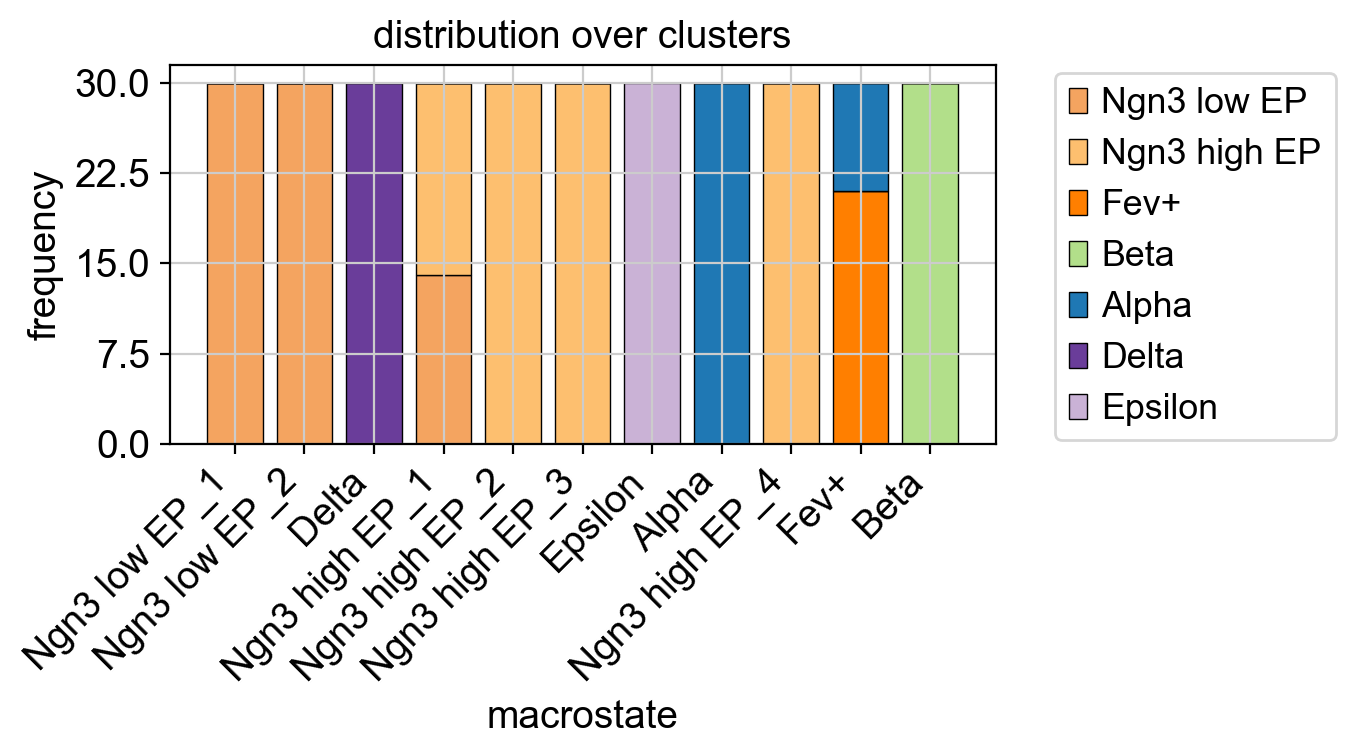

In [18]:
g2.plot_macrostate_composition(key="clusters", figsize=(7, 4))

With some exceptions, most macrostates recruit their top-cells from a single underlying cluster. This plotting function works for any observation-level covariate and can be useful when we have experimental time labels as we expect more mature states to come from later time points. See the {class}`~cellrank.kernels.TransportMapKernel` and the corresponding {doc}`tutorial <cellrank_meets_real_time>` to learn how CellRank makes use of experimental time points. 

To get an idea of how these macrostates are related, we plot the {attr}`coarse-grained transition matrix <cellrank.estimators.GPCCA.coarse_T`. 

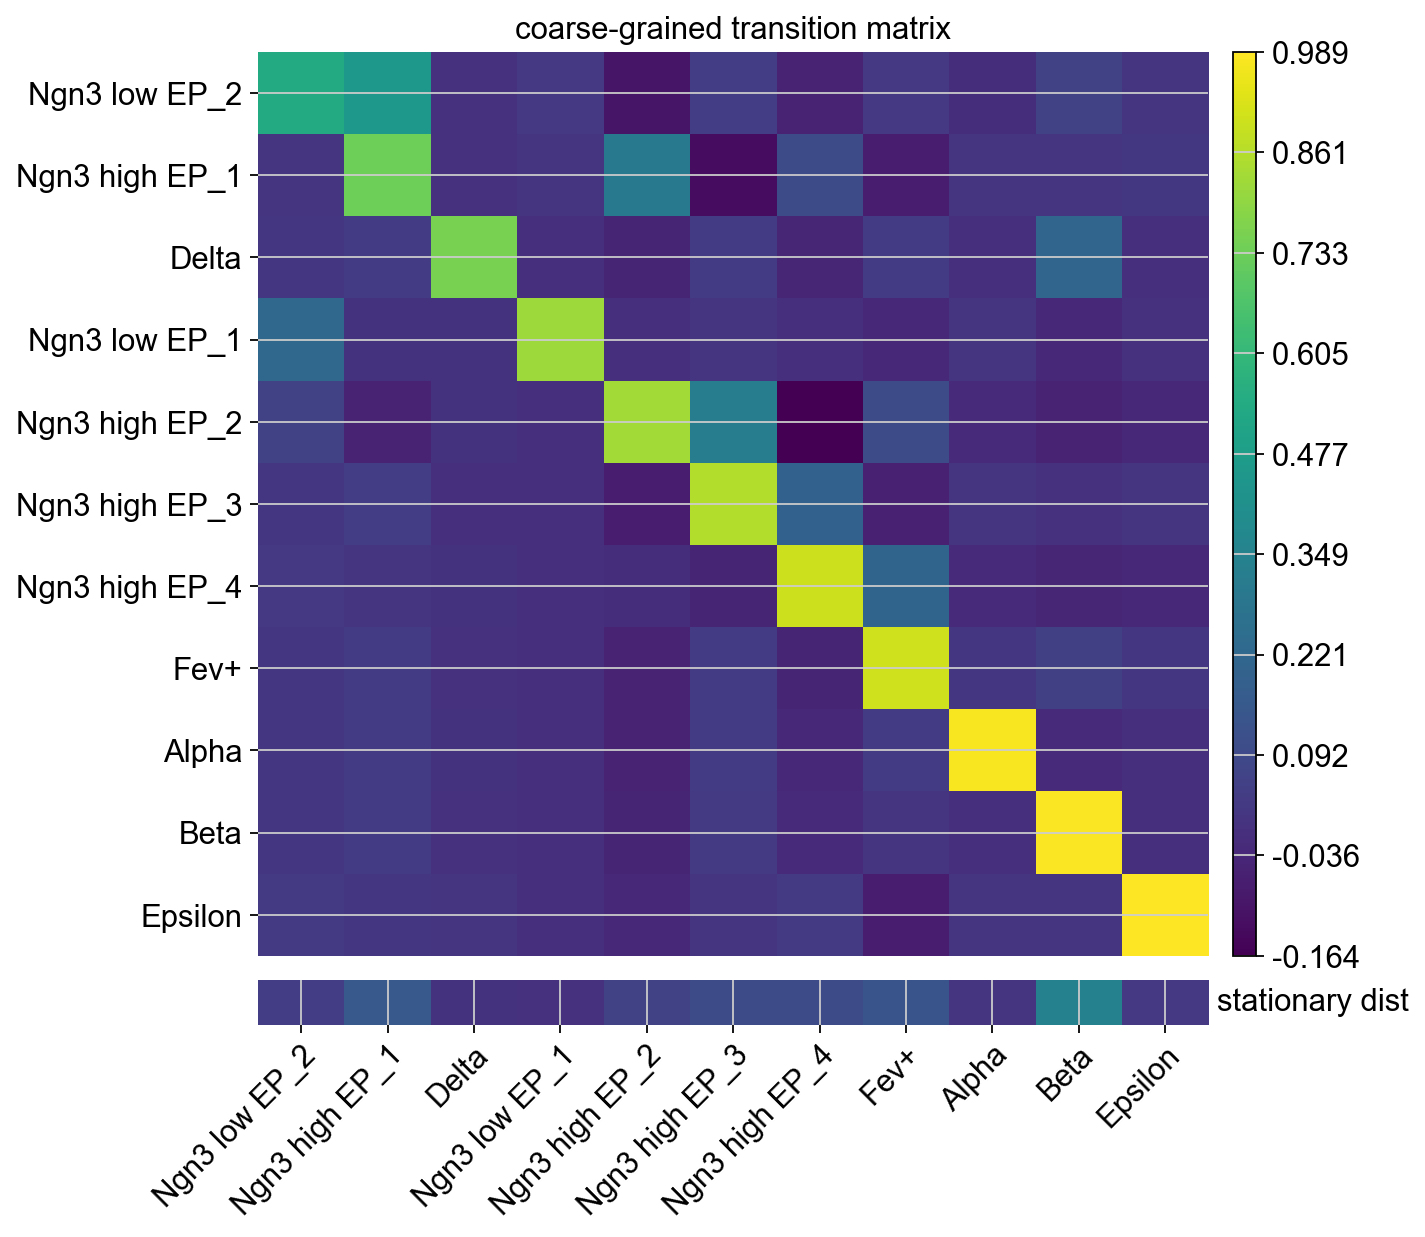

In [19]:
g2.plot_coarse_T(annotate=False)

By default, macrostates are ordered according to their diagonal value, increasing from left to right. The diagonal value is a proxy for a states' *metastability*, i.e. the probability of leaving the state once entered. While the Epsilon, Alpha and Beta states have high diagonal values, Delta cells have a low value because they are predicted to transition into Beta cells (check the corresponding matrix element). 

Let's try automatic terminal state identification. 

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


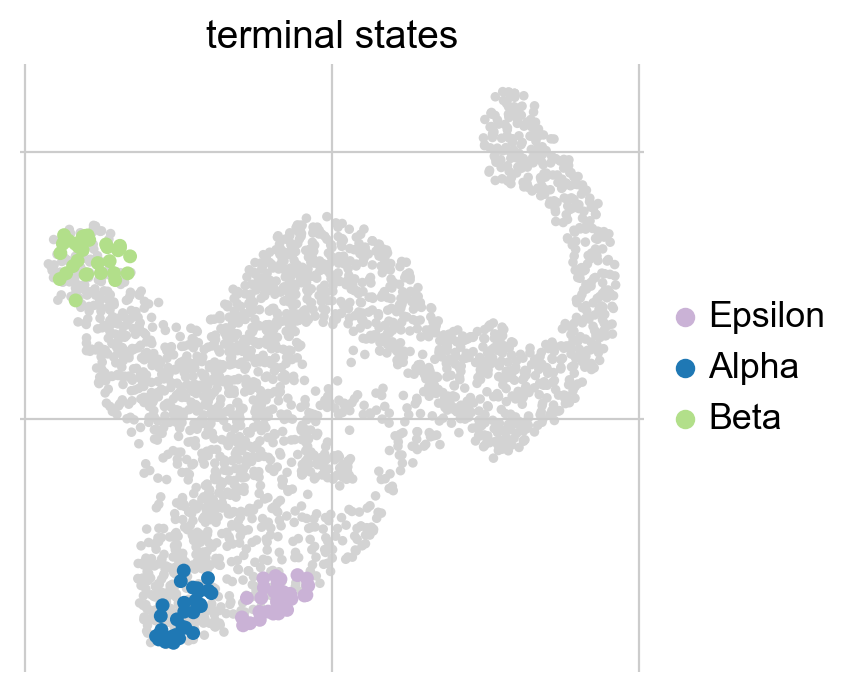

In [20]:
g2.predict_terminal_states()
g2.plot_macrostates(which="terminal", legend_loc="right", s=100)

Besides many more macrostates being present now, this consistently identified the same three terminal states as before. However, we still did not catch the Delta cells! If we want to compute {attr}`fate probabilities <cellrank.estimators.GPCCA.fate_probabilities>` towards them later on, we need to annotate them as a terminal state. Luckily, this can be done semi-automatically as well:

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


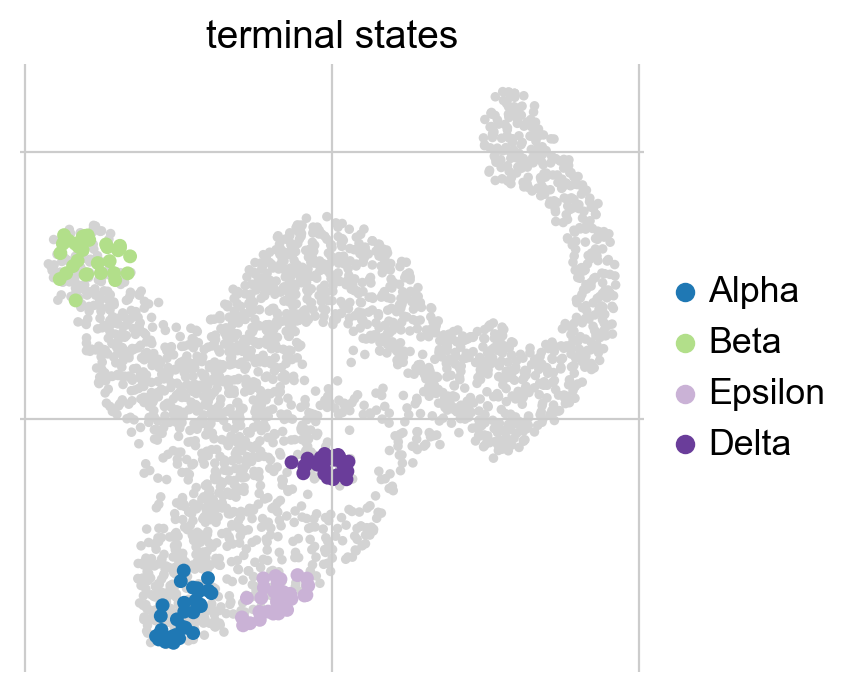

In [21]:
g2.set_terminal_states(states=["Alpha", "Beta", "Epsilon", "Delta"])
g2.plot_macrostates(which="terminal", legend_loc="right", s=100)

We call this semi-automatic terminal state identification as we manually pass the macrostates we would like to select, however, the actual cells belonging to each macrostate are assigned automatically. For initial states, everything works exactly the same, you can identify them fully automatically, or semi-automatically. Let's compute the initial states fully automatically here: 

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


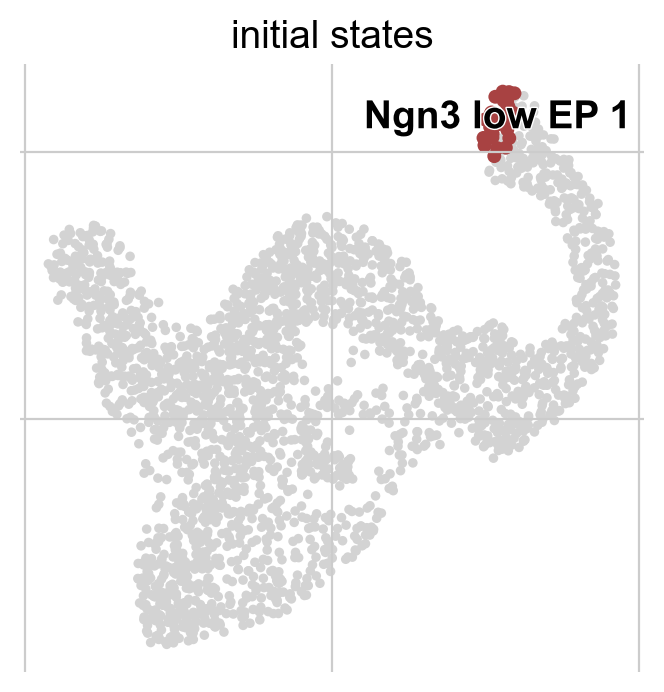

In [22]:
g2.predict_initial_states()
g2.plot_macrostates(which="initial", s=100)

How can we check whether this is really the correct initial state? In this case, we have prior knowledge that we can use: we know that the initial state should be high for a number of Ductal cell markers. So let's use these markers to compute a score that we can visualize across macrostates to confirm that we have the correct one. 

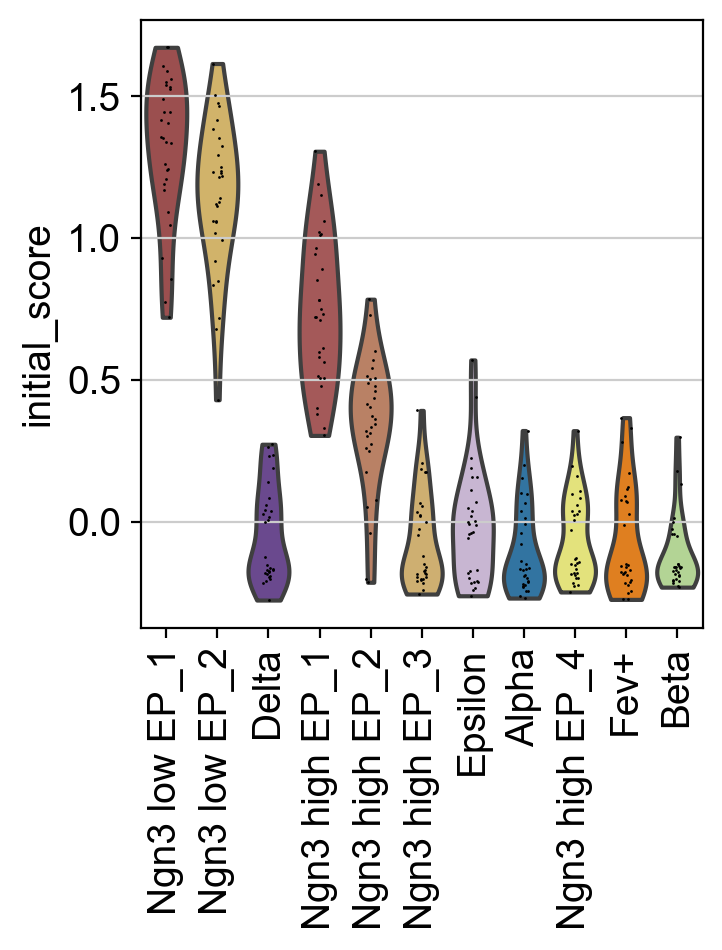

In [23]:
# compute a score in scanpy by aggregating across a few ductal markers
sc.tl.score_genes(
    adata, gene_list=["Bicc1", "Sox9", "Anxa2"], score_name="initial_score"
)

# write macrostates to AnnData
adata.obs["macrostates"] = g2.macrostates
adata.uns["macrostates_colors"] = g2.macrostates_memberships.colors

# visualize via heatmaps
sc.pl.violin(adata, keys="initial_score", groupby="macrostates", rotation=90)

In fact, the `'Ngn3 low EP_1'` state scores highest, confirming the identification of this state as as initial state. The same strategy can be used to confirm terminal state identification, or to guide semi-automatic identification in the first place. 

## Closing matters

### What's next? 

In this tutorial, you learned how to use CellRank's {class}`GPCCA estimator <cellrank.estimators.GPCCA>` to compute initial and terminal states of cellular dynamics. For the next steps, we recommend to: 

- go through the {doc}`fate probabilities & driver genes tutorial <fate_probabilities>` to learn how to quantify cellular fate commitment. 
- take a look at the {class}`API <cellrank.estimators.GPCCA>` to learn about parameter values you can use to adapt these computations to your data. 
-  read the original GPCCA publications to get familiar with the maths and ideas behind these computations {cite}`reuter:18, reuter:19`. 

### Package versions

In [24]:
cr.logging.print_versions()

cellrank==1.5.2.dev206+ga2748bea scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
